In [99]:
# No need to be executed. Data stored in local files.

from linkedin_api import Linkedin

# LinkedIn Credentials
email = ''
password = ''

# Authenticate using any LinkedIn user account credentials
# Cookies must be refreshed to avoid empty results. User must be signed out from browser/app before executin code.
api = Linkedin(email, password, refresh_cookies=True)

In [101]:
# No need to be executed. Data stored in local files.

jobs = api.search_jobs(location_name='Bulgaria')

In [105]:
# No need to be executed. Data stored in local files.

import json

file_path = "allJobs.json"

# Write the object to the file
with open(file_path, "w") as file:
    json.dump(jobs, file, indent=4)

print(f"Object saved to {file_path}")

Object saved to allJobs.json


In [107]:
# No need to be executed. Data stored in local files.

output_file = 'jobDetails.json'

# Iterate over the jobs
job_details = []
for job in jobs:
    # Extract the job ID from the trackingUrn
    urn = job.get("trackingUrn", "")
    job_id = urn.split(":")[-1]  # Get the last part of the urn

    # Make an API call to fetch job details
    details = api.get_job(job_id=job_id)
    
    job_details.append(details)

# Save the details to a file
with open(output_file, "w") as file:
    json.dump(job_details, file, indent=4)

print(f"Job details saved to {output_file}")

Job details saved to jobDetails.json


In [133]:
# Start data preprocessing from here.

import pandas as pd

# Path to the files
all_jobs = 'allJobs.json'

# Load the files into a DataFrames
jobs_json = pd.read_json(all_jobs)
jobs_df = pd.DataFrame(jobs_json)

job_details = 'jobDetails.json'

def flatten_json(y):
    """Flatten a nested JSON object."""
    out = {}

    def flatten(x, name=''):
        if isinstance(x, dict):
            for key in x:
                flatten(x[key], name + key + '_')
        elif isinstance(x, list):
            for i, item in enumerate(x):
                flatten(item, name + str(i) + '_')
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Load JSON data from the file
with open(job_details, 'r') as file:
    job_details_json_data = json.load(file)

# Remove the 'attributes' key from each element
for element in job_details_json_data:
    if "description" in element and "attributes" in element["description"]:
        del element["description"]["attributes"]
    if "companyDetails" in element:
        company_details = element["companyDetails"].get(
            "com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany", {}
        )
        company_resolution_result = company_details.get("companyResolutionResult", {})
        logo = company_resolution_result.get("logo", {})
        
        if "image" in logo:
            del logo["image"]


# Flatten the JSON
flattened_job_details__data = [flatten_json(element) for element in job_details_json_data]

details_df = pd.DataFrame(flattened_job_details__data)

# Display the DataFrame
details_df

,dashEntityUrn,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_entityUrn,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_name,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_logo_type,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_$recipeType,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_universalName,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_url,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_company,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_$recipeType,jobState,...,workplaceTypesResolutionResults_urn:li:fs_workplaceType:3_localizedName,workplaceTypesResolutionResults_urn:li:fs_workplaceType:3_$recipeType,workplaceTypesResolutionResults_urn:li:fs_workplaceType:3_entityUrn,workplaceTypesResolutionResults_urn:li:fs_workplaceType:1_localizedName,workplaceTypesResolutionResults_urn:li:fs_workplaceType:1_$recipeType,workplaceTypesResolutionResults_urn:li:fs_workplaceType:1_entityUrn,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_unifyApplyEnabled,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_easyApplyUrl,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_companyApplyUrl,companyDetails_com.linkedin.voyager.jobs.JobPostingCompanyName_companyName
0,urn:li:fsd_jobPosting:4109184889,urn:li:fs_normalized_company:5240076,myGwork - LGBTQ+ Business Community,SQUARE_LOGO,com.linkedin.voyager.deco.organization.shared....,mygwork,https://www.linkedin.com/company/mygwork,urn:li:fs_normalized_company:5240076,com.linkedin.voyager.deco.jobs.web.shared.WebC...,LISTED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,urn:li:fsd_jobPosting:4051815637,urn:li:fs_normalized_company:11259345,Keyrock,SQUARE_LOGO,com.linkedin.voyager.deco.organization.shared....,keyrock,https://www.linkedin.com/company/keyrock,urn:li:fs_normalized_company:11259345,com.linkedin.voyager.deco.jobs.web.shared.WebC...,LISTED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,urn:li:fsd_jobPosting:4109982293,urn:li:fs_normalized_company:2567862,Scalefocus,SQUARE_LOGO,com.linkedin.voyager.deco.organization.shared....,scalefocus,https://www.linkedin.com/company/scalefocus,urn:li:fs_normalized_company:2567862,com.linkedin.voyager.deco.jobs.web.shared.WebC...,LISTED,...,Hybrid,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,urn:li:fsd_jobPosting:4110891714,urn:li:fs_normalized_company:1180171,TELUS Digital Spain,SQUARE_LOGO,com.linkedin.voyager.deco.organization.shared....,telusdigitalspain,https://www.linkedin.com/showcase/telusdigital...,urn:li:fs_normalized_company:1180171,com.linkedin.voyager.deco.jobs.web.shared.WebC...,LISTED,...,NaN,NaN,NaN,On-site,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:1,NaN,NaN,NaN,NaN
4,urn:li:fsd_jobPosting:3773781834,urn:li:fs_normalized_company:165726,ResultsCX,SQUARE_LOGO,com.linkedin.voyager.deco.organization.shared....,resultscx,https://www.linkedin.com/company/resultscx,urn:li:fs_normalized_company:165726,com.linkedin.voyager.deco.jobs.web.shared.WebC...,LISTED,...,NaN,NaN,NaN,On-site,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,urn:li:fsd_jobPosting:4110458133,urn:li:fs_normalized_company:74857785,Kaderabotim.bg,SQUARE_LOGO,com.linkedin.voyager.deco.organization.shared....,kaderabotim-bg,https://www.linkedin.com/company/kaderabotim-bg,urn:li:fs_normalized_company:74857785,com.linkedin.voyager.deco.jobs.web.shared.WebC...,LISTED,...,NaN,NaN,NaN,On-site,com.

In [134]:
# Build a jobPostingId column in jobs_df to be able to merge both dataframes
jobs_df['jobPostingId'] = jobs_df['entityUrn'].str.split(':').str[-1]

jobs_df['jobPostingId'] = jobs_df['jobPostingId'].astype(str)
details_df['jobPostingId'] = details_df['jobPostingId'].astype(str)

# Merging the dataframes on 'jobPostingId' column
merged_df = pd.merge(jobs_df, details_df, on='jobPostingId', suffixes=('', '_drop'))

# Drop the column with the '_drop' suffix (automatically created for duplicate columns)
merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_drop')]
merged_df

,trackingUrn,repostedJob,title,$recipeTypes,posterId,$type,contentSource,entityUrn,jobPostingId,dashEntityUrn,...,workplaceTypesResolutionResults_urn:li:fs_workplaceType:3_localizedName,workplaceTypesResolutionResults_urn:li:fs_workplaceType:3_$recipeType,workplaceTypesResolutionResults_urn:li:fs_workplaceType:3_entityUrn,workplaceTypesResolutionResults_urn:li:fs_workplaceType:1_localizedName,workplaceTypesResolutionResults_urn:li:fs_workplaceType:1_$recipeType,workplaceTypesResolutionResults_urn:li:fs_workplaceType:1_entityUrn,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_unifyApplyEnabled,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_easyApplyUrl,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_companyApplyUrl,companyDetails_com.linkedin.voyager.jobs.JobPostingCompanyName_companyName
0,urn:li:jobPosting:4109184889,True,Associate Director/Research Scientist - Health...,[com.linkedin.deco.recipe.anonymous.Anon157894...,7.850910e+08,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4109184889,4109184889,urn:li:fsd_jobPosting:4109184889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,urn:li:jobPosting:4051815637,True,Head of Engineering - High Frequency Trading (...,[com.linkedin.deco.recipe.anonymous.Anon157894...,1.053755e+09,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4051815637,4051815637,urn:li:fsd_jobPosting:4051815637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,urn:li:jobPosting:4109982293,False,User Experience Designer,[com.linkedin.deco.recipe.anonymous.Anon157894...,3.086214e+08,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4109982293,4109982293,urn:li:fsd_jobPosting:4109982293,...,Hybrid,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,urn:li:jobPosting:4110891714,False,Technical Support Specialist with French and E...,[com.linkedin.deco.recipe.anonymous.Anon157894...,1.257631e+09,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4110891714,4110891714,urn:li:fsd_jobPosting:4110891714,...,NaN,NaN,NaN,On-site,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:1,NaN,NaN,NaN,NaN
4,urn:li:jobPosting:3773781834,True,Customer Service Representative with English -...,[com.linkedin.deco.recipe.anonymous.Anon157894...,5.101843e+06,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:3773781834,3773781834,urn:li:fsd_jobPosting:3773781834,...,NaN,NaN,NaN,On-site,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,urn:li:jobPosting:4110458133,False,Senior Dynamics 365 Finance Consultant,[com.linkedin.deco.recipe.anonymous.Anon157894...,NaN,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_CREATE,urn:li:fsd_jobPosting:4110458133,4110458133,urn:li:fsd_jobPosting:4110458133,...,NaN,NaN,NaN,On-site,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:1,NaN,NaN,NaN,NaN
257,urn:li:jobPosting:4110458137,False,Senior Business Analyst (ETRM),[com.linkedin.deco.recipe.anonymous.Anon157894...,NaN,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_CREATE,urn:li:fsd_jobPosting:4110458137,4110458137,urn:li:fsd_jobPosting:4110458137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,urn:li:jobPosting:4110458136,False,Senior UI/UX Designer,[com.linkedin.deco.recipe.anonymous.Anon157894...,NaN,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_CREATE,urn:li:fsd_jobPosting:4110458136,4110458136,urn:li:fsd_jobPosting:4110458136,...,NaN,NaN,NaN,On-site,com.linkedin.voyager.deco.jobs.shared.WebJobDe...,urn:li:fs_workplaceType:1,NaN,NaN,NaN,NaN
259,urn:li:jobPosting:4110456358,False,Strategy Manager (Key Accounts),[com.linkedin.deco.recipe.anonymous.Anon157894...,NaN,com.linkedin.voyager.dash.jobs.JobPosting,JOBS_CREATE,urn:li:fs

In [135]:
for col in merged_df.columns:
    try:
        print(f"{col}: {merged_df[col].nunique()} unique values")
    except TypeError as e:
        print(f"Error in column '{col}': {e}")

trackingUrn: 261 unique values
repostedJob: 2 unique values
title: 227 unique values
Error in column '$recipeTypes': unhashable type: 'list'
posterId: 107 unique values
$type: 1 unique values
contentSource: 3 unique values
entityUrn: 261 unique values
jobPostingId: 261 unique values
dashEntityUrn: 261 unique values
companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_entityUrn: 114 unique values
companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_name: 114 unique values
companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_logo_type: 1 unique values
companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_$recipeType: 1 unique values
companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_universalName: 114 unique val

In [136]:
merged_df['$recipeTypes'] = merged_df['$recipeTypes'].apply(lambda x: str(x) if isinstance(x, list) else x)

In [137]:
# Remove columns with only one unique value
merged_df.columns = merged_df.columns.map(lambda x: str(x) if isinstance(x, list) else x)
unique_columns_df = merged_df.loc[:, merged_df.nunique() > 1].copy()
unique_columns_df

,trackingUrn,repostedJob,title,posterId,contentSource,entityUrn,jobPostingId,dashEntityUrn,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_entityUrn,companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_name,...,description_text,workRemoteAllowed,applyMethod_com.linkedin.voyager.jobs.OffsiteApply_applyStartersPreferenceVoid,applyMethod_com.linkedin.voyager.jobs.OffsiteApply_companyApplyUrl,formattedLocation,workplaceTypes_0,listedAt,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_easyApplyUrl,applyMethod_com.linkedin.voyager.jobs.ComplexOnsiteApply_companyApplyUrl,companyDetails_com.linkedin.voyager.jobs.JobPostingCompanyName_companyName
0,urn:li:jobPosting:4109184889,True,Associate Director/Research Scientist - Health...,7.850910e+08,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4109184889,4109184889,urn:li:fsd_jobPosting:4109184889,urn:li:fs_normalized_company:5240076,myGwork - LGBTQ+ Business Community,...,"This job is with Thermo Fisher Scientific, an ...",True,True,https://mygwork.com/jobs/thermo-fisher-scienti...,Bulgaria,urn:li:fs_workplaceType:2,1735262323000,NaN,NaN,NaN
1,urn:li:jobPosting:4051815637,True,Head of Engineering - High Frequency Trading (...,1.053755e+09,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4051815637,4051815637,urn:li:fsd_jobPosting:4051815637,urn:li:fs_normalized_company:11259345,Keyrock,...,Head of Engineering - Market Making Services\n...,True,True,https://jobs.ashbyhq.com/keyrock/45c757d4-af6d...,European Economic Area,urn:li:fs_workplaceType:2,1735304372000,NaN,NaN,NaN
2,urn:li:jobPosting:4109982293,False,User Experience Designer,3.086214e+08,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4109982293,4109982293,urn:li:fsd_jobPosting:4109982293,urn:li:fs_normalized_company:2567862,Scalefocus,...,Scalefocus provides tailored software solution...,False,NaN,NaN,"Sofia City, Bulgaria",urn:li:fs_workplaceType:3,1735233442000,NaN,NaN,NaN
3,urn:li:jobPosting:4110891714,False,Technical Support Specialist with French and E...,1.257631e+09,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4110891714,4110891714,urn:li:fsd_jobPosting:4110891714,urn:li:fs_normalized_company:1180171,TELUS Digital Spain,...,You are an enthusiastic and adventurous person...,False,True,https://jobs.telusdigital.com/en_US/careers/Pi...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735302077000,NaN,NaN,NaN
4,urn:li:jobPosting:3773781834,True,Customer Service Representative with English -...,5.101843e+06,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:3773781834,3773781834,urn:li:fsd_jobPosting:3773781834,urn:li:fs_normalized_company:165726,ResultsCX,...,Customer Service Representative with English -...,False,True,https://careers.resultscx.com/job-detail/custo...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735226023000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,urn:li:jobPosting:4110458133,False,Senior Dynamics 365 Finance Consultant,NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110458133,4110458133,urn:li:fsd_jobPosting:4110458133,urn:li:fs_normalized_company:74857785,Kaderabotim.bg,...,Kaderabotim.bg on behalf of:\n\ntalaint by Hum...,False,False,https://www.kaderabotim.bg/en/jobs/senior-dyna...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735260418000,NaN,NaN,NaN
257,urn:li:jobPosting:4110458137,False,Senior Business Analyst (ETRM),NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110458137,4110458137,urn:li:fsd_jobPosting:4110458137,urn:li:fs_normalized_company:74857785,Kaderabotim.bg,...,Kaderabotim.bg on behalf of:\n\ntalaint by Hum...,True,False,https://www.kaderabotim.bg/en/jobs/senior-busi...,Bulgaria,urn:li:fs_workplaceType:2,1735260422000,NaN,NaN,NaN
258,urn:li:jobPosting:4110458136,False,Senior UI/UX Designer,NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110458136,4110458136,urn:li:fsd_jobPosting:4110458136,urn:li:fs_normalized_company:74857785,

In [138]:
print(unique_columns_df.columns)

Index(['trackingUrn', 'repostedJob', 'title', 'posterId', 'contentSource',
       'entityUrn', 'jobPostingId', 'dashEntityUrn',
       'companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_entityUrn',
       'companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_name',
       'companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_universalName',
       'companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_companyResolutionResult_url',
       'companyDetails_com.linkedin.voyager.deco.jobs.web.shared.WebCompactJobPostingCompany_company',
       'description_text', 'workRemoteAllowed',
       'applyMethod_com.linkedin.voyager.jobs.OffsiteApply_applyStartersPreferenceVoid',
       'applyMethod_com.linkedin.voyager.jobs.OffsiteApply_companyApplyUrl',
       'formattedLocation', 'workplaceTypes_0'

In [139]:
def simplify_column_name(col_name):
    parts = col_name.split('_')
    
    if len(parts) > 1:
        # Keep the first part and the last part
        return f"{parts[0]}_{parts[-1]}"
    return col_name  

unique_columns_df.columns = [simplify_column_name(col) for col in unique_columns_df.columns]
print(unique_columns_df.columns)

Index(['trackingUrn', 'repostedJob', 'title', 'posterId', 'contentSource',
       'entityUrn', 'jobPostingId', 'dashEntityUrn',
       'companyDetails_entityUrn', 'companyDetails_name',
       'companyDetails_universalName', 'companyDetails_url',
       'companyDetails_company', 'description_text', 'workRemoteAllowed',
       'applyMethod_applyStartersPreferenceVoid',
       'applyMethod_companyApplyUrl', 'formattedLocation', 'workplaceTypes_0',
       'listedAt', 'applyMethod_easyApplyUrl', 'applyMethod_companyApplyUrl',
       'companyDetails_companyName'],
      dtype='object')


In [140]:
unique_columns_df

,trackingUrn,repostedJob,title,posterId,contentSource,entityUrn,jobPostingId,dashEntityUrn,companyDetails_entityUrn,companyDetails_name,...,description_text,workRemoteAllowed,applyMethod_applyStartersPreferenceVoid,applyMethod_companyApplyUrl,formattedLocation,workplaceTypes_0,listedAt,applyMethod_easyApplyUrl,applyMethod_companyApplyUrl,companyDetails_companyName
0,urn:li:jobPosting:4109184889,True,Associate Director/Research Scientist - Health...,7.850910e+08,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4109184889,4109184889,urn:li:fsd_jobPosting:4109184889,urn:li:fs_normalized_company:5240076,myGwork - LGBTQ+ Business Community,...,"This job is with Thermo Fisher Scientific, an ...",True,True,https://mygwork.com/jobs/thermo-fisher-scienti...,Bulgaria,urn:li:fs_workplaceType:2,1735262323000,NaN,NaN,NaN
1,urn:li:jobPosting:4051815637,True,Head of Engineering - High Frequency Trading (...,1.053755e+09,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4051815637,4051815637,urn:li:fsd_jobPosting:4051815637,urn:li:fs_normalized_company:11259345,Keyrock,...,Head of Engineering - Market Making Services\n...,True,True,https://jobs.ashbyhq.com/keyrock/45c757d4-af6d...,European Economic Area,urn:li:fs_workplaceType:2,1735304372000,NaN,NaN,NaN
2,urn:li:jobPosting:4109982293,False,User Experience Designer,3.086214e+08,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4109982293,4109982293,urn:li:fsd_jobPosting:4109982293,urn:li:fs_normalized_company:2567862,Scalefocus,...,Scalefocus provides tailored software solution...,False,NaN,NaN,"Sofia City, Bulgaria",urn:li:fs_workplaceType:3,1735233442000,NaN,NaN,NaN
3,urn:li:jobPosting:4110891714,False,Technical Support Specialist with French and E...,1.257631e+09,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:4110891714,4110891714,urn:li:fsd_jobPosting:4110891714,urn:li:fs_normalized_company:1180171,TELUS Digital Spain,...,You are an enthusiastic and adventurous person...,False,True,https://jobs.telusdigital.com/en_US/careers/Pi...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735302077000,NaN,NaN,NaN
4,urn:li:jobPosting:3773781834,True,Customer Service Representative with English -...,5.101843e+06,JOBS_PREMIUM_OFFLINE,urn:li:fsd_jobPosting:3773781834,3773781834,urn:li:fsd_jobPosting:3773781834,urn:li:fs_normalized_company:165726,ResultsCX,...,Customer Service Representative with English -...,False,True,https://careers.resultscx.com/job-detail/custo...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735226023000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,urn:li:jobPosting:4110458133,False,Senior Dynamics 365 Finance Consultant,NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110458133,4110458133,urn:li:fsd_jobPosting:4110458133,urn:li:fs_normalized_company:74857785,Kaderabotim.bg,...,Kaderabotim.bg on behalf of:\n\ntalaint by Hum...,False,False,https://www.kaderabotim.bg/en/jobs/senior-dyna...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735260418000,NaN,NaN,NaN
257,urn:li:jobPosting:4110458137,False,Senior Business Analyst (ETRM),NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110458137,4110458137,urn:li:fsd_jobPosting:4110458137,urn:li:fs_normalized_company:74857785,Kaderabotim.bg,...,Kaderabotim.bg on behalf of:\n\ntalaint by Hum...,True,False,https://www.kaderabotim.bg/en/jobs/senior-busi...,Bulgaria,urn:li:fs_workplaceType:2,1735260422000,NaN,NaN,NaN
258,urn:li:jobPosting:4110458136,False,Senior UI/UX Designer,NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110458136,4110458136,urn:li:fsd_jobPosting:4110458136,urn:li:fs_normalized_company:74857785,Kaderabotim.bg,...,Kaderabotim.bg on behalf of:\n\ntalaint by Hum...,False,False,https://www.kaderabotim.bg/en/jobs/senior-uiux...,"Sofia, Sofia City, Bulgaria",urn:li:fs_workplaceType:1,1735260421000,NaN,NaN,NaN
259,urn:li:jobPosting:4110456358,False,Strategy Manager (Key Accounts),NaN,JOBS_CREATE,urn:li:fsd_jobPosting:4110456358,4110456358,urn:li:fsd_jobPosting:4110456358,urn:li:fs_normalized_compan

In [141]:
unique_columns_df.isnull().sum()

trackingUrn                                  0
repostedJob                                  0
title                                        0
posterId                                    45
contentSource                                0
entityUrn                                    0
jobPostingId                                 0
dashEntityUrn                                0
companyDetails_entityUrn                     3
companyDetails_name                          3
companyDetails_universalName                 3
companyDetails_url                           3
companyDetails_company                       3
description_text                             0
workRemoteAllowed                            0
applyMethod_applyStartersPreferenceVoid    132
applyMethod_companyApplyUrl                132
formattedLocation                            0
workplaceTypes_0                             3
listedAt                                     0
applyMethod_easyApplyUrl                   139
applyMethod_c

In [142]:
unique_columns_df['companyDetails_name'] = unique_columns_df['companyDetails_name'].combine_first(unique_columns_df['companyDetails_companyName'])

unique_columns_df.iloc[:, 16] = unique_columns_df.iloc[:, 16].combine_first(unique_columns_df.iloc[:, 21])

In [143]:
unique_columns_df.drop(unique_columns_df.columns[22], axis=1, inplace=True)
unique_columns_df.drop(unique_columns_df.columns[21], axis=1,inplace=True)

In [144]:
unique_columns_df.isnull().sum()

trackingUrn                                  0
repostedJob                                  0
title                                        0
posterId                                    45
contentSource                                0
entityUrn                                    0
jobPostingId                                 0
dashEntityUrn                                0
companyDetails_entityUrn                     3
companyDetails_name                          0
companyDetails_universalName                 3
companyDetails_url                           3
companyDetails_company                       3
description_text                             0
workRemoteAllowed                            0
applyMethod_applyStartersPreferenceVoid    132
formattedLocation                            0
workplaceTypes_0                             3
listedAt                                     0
applyMethod_easyApplyUrl                   139
dtype: int64

In [153]:
unique_columns_df['formattedLocation'].value_counts()

formattedLocation
Sofia, Sofia City, Bulgaria          88
European Union                       59
EMEA                                 56
Bulgaria                             23
European Economic Area                8
Sofia City, Bulgaria                  4
Plovdiv, Plovdiv, Bulgaria            4
Sofia, Bulgaria                       4
Sofia Metropolitan Area               2
Varna, Varna, Bulgaria                2
Plovdiv, Bulgaria                     1
Samokov, Sofia, Bulgaria              1
Devnya, Varna, Bulgaria               1
Chernoochene, Kurdzhali, Bulgaria     1
Stolnik, Sofia, Bulgaria              1
Greater Yambol Area                   1
Burgas, Bulgaria                      1
Vetrino, Varna, Bulgaria              1
Asenovgrad, Plovdiv, Bulgaria         1
Yambol, Bulgaria                      1
Burgas, Burgas, Bulgaria              1
Name: count, dtype: int64

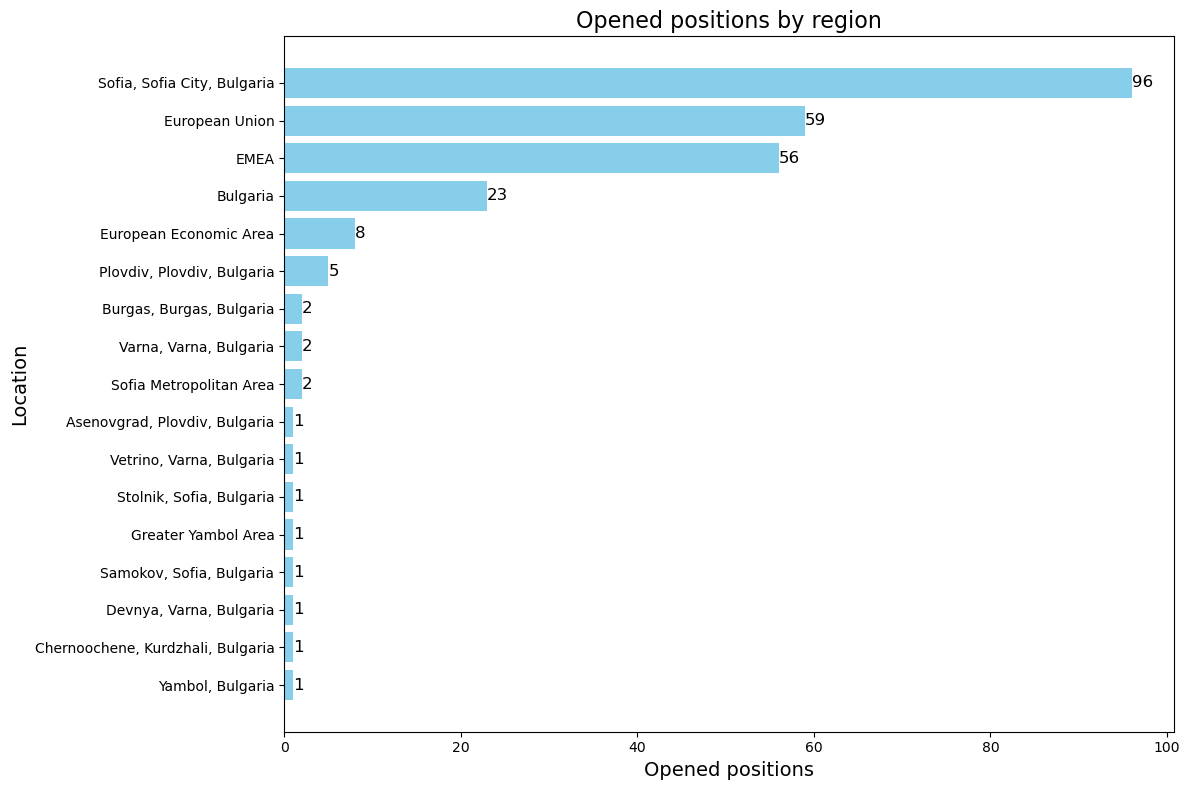

In [171]:
import matplotlib.pyplot as plt

#Create a dataframe only with locations and their count
locations_df = unique_columns_df['formattedLocation'].value_counts().reset_index()
locations_df.columns = ['formattedLocation', 'count']

# Merge identical columns
locations_df['formattedLocation'] = locations_df['formattedLocation'].replace(
    'Sofia City, Bulgaria', 'Sofia, Sofia City, Bulgaria'
).replace(
    'Sofia, Bulgaria', 'Sofia, Sofia City, Bulgaria'
).replace(
    'Burgas, Bulgaria', 'Burgas, Burgas, Bulgaria'
).replace(
    'Plovdiv, Bulgaria', 'Plovdiv, Plovdiv, Bulgaria'
)

merged_locations_df= locations_df.groupby('formattedLocation', as_index=False)['count'].sum()

# Sort data by count for better visualization
merged_locations_df = merged_locations_df.sort_values(by="count", ascending=False)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(merged_locations_df["formattedLocation"], merged_locations_df["count"], color="skyblue")
plt.xlabel("Opened positions", fontsize=14)
plt.ylabel("Location", fontsize=14)
plt.title("Opened positions by region", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Adding the values on the bars
for bar, count in zip(bars, merged_locations_df["count"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,  # Position the text
             str(count), va='center', ha='left', fontsize=12)  # Place count value to the right of the bar

plt.tight_layout()
plt.show()

In [185]:
unique_columns_df['repostedJob'].value_counts()

repostedJob
False    205
True      56
Name: count, dtype: int64

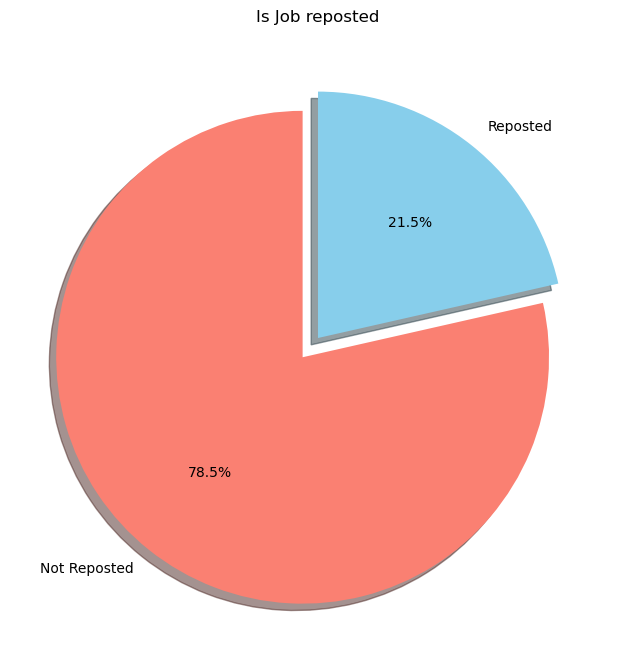

In [192]:
# pie chart
plt.figure(figsize=(8, 8))
type_counts.plot.pie(
    autopct='%1.1f%%',  # Show percentages
    labels=['Not Reposted', 'Reposted'], 
    startangle=90,  # Rotate the pie chart for better visual
    colors=['salmon', 'skyblue'],
    explode=[0.1, 0],
    shadow=True
)

plt.title('Is Job reposted')
plt.ylabel('')
plt.show()